In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import torch
import gc
import os
import sys
%matplotlib notebook
import matplotlib.pyplot as plt

def printmem():
    allocated = torch.cuda.memory_allocated()
    cached = torch.cuda.memory_cached()
    print('All|ocated:', str(allocated), '['+str(round(allocated/1000000000,3))+' GB]')
    print('   Cached:', str(cached), '['+str(round(cached/1000000000,3))+' GB]')

module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
printmem()



All|ocated: 0 [0.0 GB]
   Cached: 0 [0.0 GB]


In [2]:
def convout_(in_size, ker, pad, stride, dil):
    # Note, we're making an assumption of squareness
    out_size = round((in_size - 1 - dil*(ker - 1) + 2*pad) / stride + 1)
    return out_size

def convout(in_size, seq):
    for m in seq:
        if str(type(m)) == "<class 'torch.nn.modules.conv.Conv2d'>":
            ker = m.kernel_size[0]
            pad = m.padding[0]
            stride = m.stride[0]
            dil = m.dilation[0]
            in_size = convout_(in_size, ker, pad, stride, dil)
    return in_size

In [3]:
import torch.nn as nn
temp = nn.Sequential(
    nn.Conv2d(1,1,3),
    nn.ReLU(),
    nn.Conv2d(1,1,3),
    nn.ReLU(),
    nn.Conv2d(1,1,6),
    nn.ReLU()
)

In [4]:
convout(16, temp)

7

In [5]:
from criteria import MONetLoss
from helpers import Trainer
from helpers import Logger
from helpers import Trial
from mibi_dataloader import MIBIData
from rmodules import MONet
import utils

printmem()

All|ocated: 0 [0.0 GB]
   Cached: 0 [0.0 GB]


In [6]:
# # x = torch.rand(1,1,8,8)
# logsoft = nn.LogSoftmax(dim=3)
# y = logsoft(x)

# fig = plt.figure(figsize=(5,5))
# plt.imshow(y[0,0,:,:])
# plt.show()

In [7]:
# Load the data
main_dir = '/home/hazmat/Documents/mayonoise_train_synth/'
train_dir = main_dir + ''
# test_dir = main_dir + 'low_AD/'
modl_dir = main_dir + 'models/'
rslt_dir = main_dir + 'results/'

train_ds = MIBIData(folder=train_dir, crop=32, scale=1/256, stride=4, flip=True)
# test_ds = MIBIData(folder=test_dir, crop=32, scale=10, stride=16)

printmem()

['Point2.tiff', 'Point35.tiff', 'Point12.tiff', 'Point9.tiff', 'Point26.tiff', 'Point18.tiff', 'Point21.tiff', 'Point10.tiff', 'Point25.tiff', 'Point31.tiff', 'Point14.tiff', 'Point13.tiff', 'Point34.tiff', 'Point22.tiff', 'Point15.tiff', 'Point20.tiff', 'Point8.tiff', 'Point27.tiff']
Loading.......94.44444444444444%%
3844
There are  1107072 samples
All|ocated: 0 [0.0 GB]
   Cached: 0 [0.0 GB]


In [8]:
torch.mean(train_ds.__getitem__(0), dim=(1,2)).shape

torch.Size([3])

In [27]:
laddernet_args = dict()
# laddernet_args['kind'] = 'conv'

# laddernet_args['kernel_size'] = 3
# laddernet_args['padding'] = 0
# laddernet_args['dilation'] = 1
# laddernet_args['stride'] = 1

# laddernet_args['layer_dims'] = [17, 15, 13, 11, 3]
# laddernet_args['num_layers'] = 5
# laddernet_args['in_dim'] = 3
# laddernet_args['code_dim'] = 39

# laddernet_args['noise_std'] = 0

# laddernet_args['batchnorm'] = False

torch.cuda.empty_cache()
laddernet = MONet(64, **laddernet_args)

laddernet.cuda()
# print(owlnet)

fc_in: 26912
fc_in: 26912


MONet(
  (mse): L1Loss()
  (attender): Attender(
    (cnn): Sequential(
      (0): CoordConv(
        (conv): Conv2d(6, 8, kernel_size=(3, 3), stride=(1, 1))
      )
      (1): PReLU(num_parameters=1)
      (2): CoordConv(
        (conv): Conv2d(10, 8, kernel_size=(3, 3), stride=(1, 1))
      )
      (3): PReLU(num_parameters=1)
      (4): CoordConv(
        (conv): Conv2d(10, 8, kernel_size=(3, 3), stride=(1, 1))
      )
      (5): PReLU(num_parameters=1)
    )
    (mlp1): Sequential(
      (0): Linear(in_features=26912, out_features=256, bias=True)
      (1): InstanceNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): PReLU(num_parameters=1)
      (3): Linear(in_features=256, out_features=128, bias=True)
      (4): InstanceNorm1d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (5): PReLU(num_parameters=1)
    )
    (mlp2): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): InstanceNor

In [28]:
# laddernet.suggested_in_size(3)

In [29]:
laddernet_logger = Logger(['loss'])

In [30]:
laddernet_trainer = Trainer()

In [37]:
# LadderNet training parameters
laddernet_train_args = dict()
laddernet_train_args['lr'] = .0001
laddernet_train_args['batch_size'] = 32
laddernet_train_args['epochs'] = 1000
laddernet_train_args['report'] = 5
laddernet_train_args['crop'] = 64
# laddernet_train_args['clip'] = 1
laddernet_train_args['decay'] = 0
laddernet_train_args['error_cap'] = 2
# laddernet_train_args['noise_cap'] = 1
laddernet_train_args['restart'] = False
laddernet_train_args['epoch_frac'] = 0.02
# laddernet_train_args['decay'] = 1e-5

# LadderNet loss parameters
laddernet_loss_args = {
    'lambdas': [2**0, 2**-1, 2**-2, 2**-3, 2**-4, 2**-5, 2**-6, 2**-7, 2**-8, 2**-9]
}

train_ds.set_crop(laddernet_train_args['crop'])

57600


In [38]:
laddernet.cuda()
laddernet.num_steps = 5
laddernet_train_args['continue'] = False
# laddernet.set_noise_std(0)
# laddernet.set_lateral_weights(1)
# laddernet.set_vertical_weights(1)
# laddernet.set_num_steps(10)
laddernet_criterion = MONetLoss()
laddernet_trainer.train(laddernet, train_ds, laddernet_criterion, laddernet_logger, **laddernet_train_args)
print()
torch.cuda.empty_cache()
printmem()

57600
57600



/home/hazmat/GitHub/Hawkeye/rmodules.py:368: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(kwargs['x'])


Epoch:10 > < 0.12925087410285035                                      
Epoch:11 > < 0.12904391729363307                                      
Epoch:12 > < 0.12850593281866773                                      
Epoch:13 > < 0.12833794344141963                                      
Epoch:14 > < 0.12836733698064262                                      
Epoch:15 > < 0.1278296544091727                                      
Epoch:16 > < 0.12788696922304452                                      
Epoch:17 > < 0.12688011400550833                                      
Epoch:18 > < 0.12729100633889023                                      
Epoch:19 > < 0.12669462741615226                                      
Epoch:20 > < 0.12683587769284638                                      
Epoch:21 > < 0.1262476371001389                                      
Epoch:22 > < 0.12551775967303336                                      
Epoch:23 > < 0.12628315719783031                                      
Epoch:24

Epoch:239 > < 0.11713254475859905                                      
Epoch:240 > < 0.11673026841897259                                      
Epoch:241 > < 0.11697514203645415                                      
Epoch:242 > < 0.11714457877795391                                      
Epoch:243 > < 0.11676181339657361                                      
Epoch:244 > < 0.11701344240611801                                      
Epoch:245 > < 0.1166924589840216                                      
Epoch:246 > < 0.11675945723369052                                      
Epoch:247 > < 0.1171369333801725                                      
Epoch:248 > < 0.11708893463911003                                      
Epoch:249 > < 0.11715780770282716                                      
Epoch:250 > < 0.11680200405545153                                      
Epoch:251 > < 0.11683300590983524                                      
Epoch:252 > < 0.11719865858187477                                 

Epoch:467 > < 0.1161617222823237                                      
Epoch:468 > < 0.11615674708537953                                      
Epoch:469 > < 0.1159827788984647                                      
Epoch:470 > < 0.11579820224426927                                      
Epoch:471 > < 0.11571027199595661                                      
Epoch:472 > < 0.11630591441330447                                      
Epoch:473 > < 0.11558684710131956                                      
Epoch:474 > < 0.11570772167025435                                      
Epoch:475 > < 0.11590579310532527                                      
Epoch:476 > < 0.11596377570474828                                      
Epoch:477 > < 0.11642946618593346                                      
Epoch:478 > < 0.11587174909507916                                      
Epoch:479 > < 0.11544195690030126                                      
Epoch:480 > < 0.11561055719071801                                 

Epoch:695 > < 0.1154420491198913                                      
Epoch:696 > < 0.11567215210484062                                      
Epoch:697 > < 0.11531713513086315                                      
Epoch:698 > < 0.11557094548442881                                      
Epoch:699 > < 0.11613150094800812                                      
Epoch:700 > < 0.11522592726997308                                      
Epoch:701 > < 0.11536867606621494                                      
Epoch:702 > < 0.11524891358540496                                      
Epoch:703 > < 0.11613955089279977                                      
Epoch:704 > < 0.11562854224939376                                      
Epoch:705 > < 0.11539370991369977                                      
Epoch:706 > < 0.11490610899699304                                      
Epoch:707 > < 0.11573143603024755                                      
Epoch:708 > < 0.11573286183488388                                

Epoch:809 > < 0.1148152417963936                                      
Epoch:810 > < 0.11529863894399031                                      
Epoch:811 > < 0.11511713136647625                                      
Epoch:812 > < 0.11437534911698663                                      
Epoch:813 > < 0.11511602771622007                                      
Epoch:814 > < 0.11508249556889703                                      
Epoch:815 > < 0.11513933262720313                                      
Epoch:816 > < 0.11556373740932424                                      
Epoch:817 > < 0.11488657730569825                                      
Epoch:818 > < 0.11541719348937594                                      
Epoch:819 > < 0.11520395849261703                                      
Epoch:820 > < 0.11544414600486565                                      
Epoch:821 > < 0.11517327620959245                                      
Epoch:822 > < 0.11593827650019861                                

In [61]:
batch = train_ds.get_batch(1, False)
x = batch['x']

/home/hazmat/GitHub/Hawkeye/mibi_dataloader.py:364: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'x': torch.tensor(sample).float().cuda(),


<IPython.core.display.Javascript object>


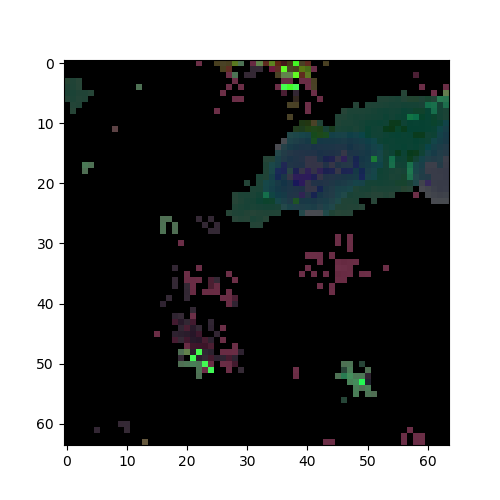

tensor(0.9883, device='cuda:0')

In [62]:
fig1 = plt.figure(figsize=(5,5))
plt.imshow(x[0,:,:,:].transpose(0,1).transpose(1,2).detach().cpu())
torch.max(x)

In [66]:
output = laddernet.predict(**batch)

/home/hazmat/GitHub/Hawkeye/rmodules.py:396: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(kwargs['x'])
/home/hazmat/GitHub/Hawkeye/rmodules.py:413: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xs.append(torch.tensor(x_k))


<IPython.core.display.Javascript object>


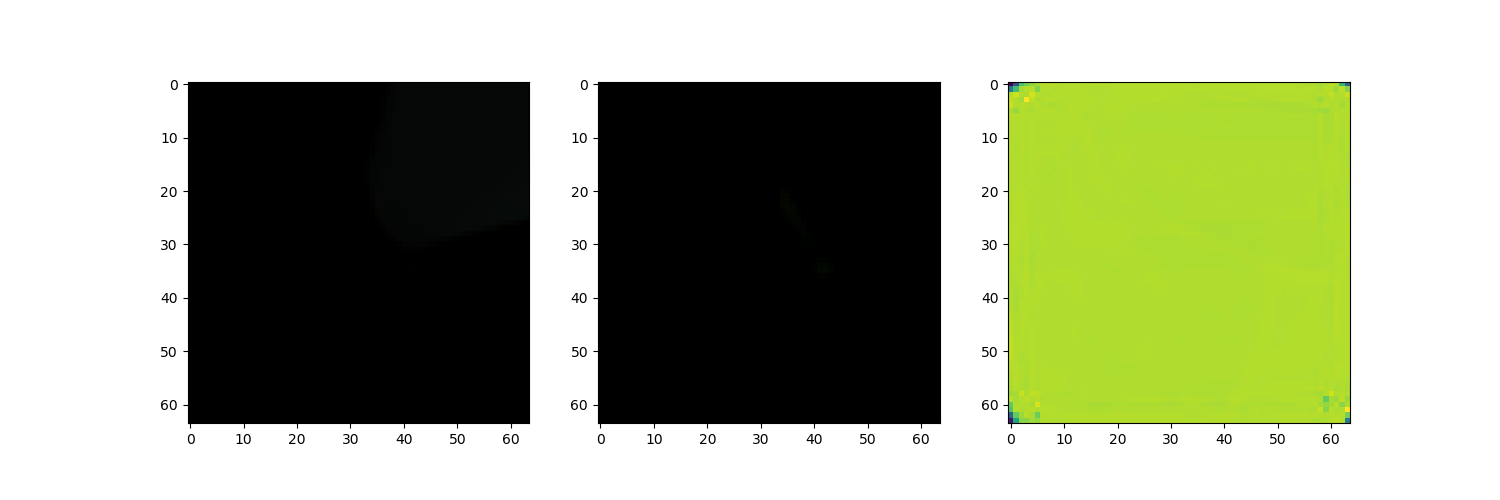

torch.Size([1, 3, 64, 64])


In [75]:
idx = 3

fig2 = plt.figure(figsize=(15,5))
ax3 = plt.subplot(1,3,1)
x_hat = output['x_hat']
plt.imshow(x_hat[0,:,:,:].transpose(0,1).transpose(1,2).detach().cpu())

ax1 = plt.subplot(1,3,2)
x_k = output['xs'][idx]
print(x_k.shape)
plt.imshow(x_k[0,:,:,:].transpose(0,1).transpose(1,2).detach().cpu())

ax2 = plt.subplot(1,3,3)
m_k = output['ms'][idx]
plt.imshow(m_k[0,0,:,:].detach().cpu())
# print(torch.max(output['ms'][4][0,0,:,:]))

In [ ]:
for i in range(len(laddernet.variables)):
    print(laddernet.variables[i].keys())
    print(laddernet.variables[i]['z'].shape)

In [ ]:
import matplotlib.pyplot as plt
fig1 = plt.figure(figsize=(9,9))

plt.plot((torch.tensor(laddernet_logger.list_vars['loss'][1])).numpy())
plt.ylim(0,2)
plt.xlabel('Minibatch Number')
plt.ylabel('Loss')
fig1.show()

In [ ]:
# laddernet = LadderNetwork.load_model('/home/hazmat/Documents/marchbrain_2/hypersearch/results/zyDe9QYT/trial_0/', 'model')
# laddernet.load(apath='/home/hazmat/Documents/2019May01_20-27-31/', file='model_99')

In [ ]:
# train_ds.set_crop(64*5)
# batch = train_ds.get_batch(1, False)
# output = laddernet(**batch)

In [ ]:
# import numpy as np
# laddernet_logger.list_vars['loss'][0]
# epochs = laddernet_logger.list_vars['loss'][0]
# lossvals = laddernet_logger.list_vars['loss'][1]
# epochs = np.reshape(epochs, len(epochs), 1)
# np.average(lossvals[-100::])

In [ ]:
import skimage
import sklearn
from sklearn.manifold import TSNE
    
def print_diff6(output1, model1, output2, model2, channel, size, blur, threshold, indices):
    import copy
    # we want to take a 
    fig = plt.figure(figsize=(1*size, 1*size))
    
    clean1 = output1['clean'][0][0,channel,:,:].detach().cpu()
    noisy1 = model1.variables[0]['z_tilda'][0,channel,:,:].detach().cpu()
    recon1 = output1['recon'][0][0,channel,:,:].detach().cpu()
    
    clean2 = output2['clean'][0][0,channel,:,:].detach().cpu()
    noisy2 = model2.variables[0]['z_tilda'][0,channel,:,:].detach().cpu()
    recon2 = output2['recon'][0][0,channel,:,:].detach().cpu()
    
    # creating blurred absolute error maps
    blurred1 = torch.tensor(skimage.filters.gaussian((torch.abs(recon1-clean1)).numpy(), blur))
    blurred2 = torch.tensor(skimage.filters.gaussian((torch.abs(recon2-clean2)).numpy(), blur))
    blurred1 = (blurred1 - torch.mean(blurred1))
    blurred2 = (blurred2 - torch.mean(blurred2))
    
    # print(blurred2.shape)
    idxs = blurred2.view(-1) > threshold;
    # print(idxs.shape)
    data2 = output2['clean'][0].permute(0,2,3,1).contiguous().view(-1,39)
    data2_list = data2[idxs,:]
    # print(data2.shape)
    cluster_mean = torch.mean(data2_list, dim=0)
    cluster_std = torch.std(data2_list, dim=0)
    cluster_std[cluster_std==0] = 1
    print(cluster_mean)
    data1 = output2['clean'][0]
    
    cluster_mean = cluster_mean.unsqueeze(0).unsqueeze(-1).unsqueeze(-1).repeat(1, 1, data1.shape[2], data1.shape[3])
    cluster_std = cluster_std.unsqueeze(0).unsqueeze(-1).unsqueeze(-1).repeat(1, 1, data1.shape[2], data1.shape[3])
    
    # indices = [0]
    
    dist = torch.sqrt(torch.sum(((output2['clean'][0][:,indices,:,:] - cluster_mean[:,indices,:,:]))**2, dim=(0,1)))
    # print(dist.shape)
    
    ax1 = plt.subplot(1,2,1)
    plt.imshow(-dist)
    
    ax2 = plt.subplot(1,2,2)
    plt.imshow(clean2)
    
    # temp2 = temp.permute(0,2,3,1).contiguous().view(-1,3)
    # data2 = output2['clean'][0].permute(0,2,3,1).contiguous().view(-1,17)
    # print(output2['clean'][0].view(0).shape)

def print_diff4(output, model, channel):
    clean = output['clean'][0][0,channel,:,:].detach().cpu()
    noisy = model.variables[0]['z_tilda'][0,channel,:,:].detach().cpu()
    recon = output['recon'][0][0,channel,:,:].detach().cpu()
    print(round(torch.mean(torch.abs(recon-clean)).item(), 4))

def print_diff2(output, model, channel, size):
    # we'going to show clean, noisy, recon, clean-recon, and noisy-recon
    fig = plt.figure(figsize=(3*size, 2*size))
    clean = output['clean'][0][0,channel,:,:].detach().cpu()
    noisy = model.variables[0]['z_tilda'][0,channel,:,:].detach().cpu()
    recon = output['recon'][0][0,channel,:,:].detach().cpu()
    # plot clean
    ax1 = plt.subplot(2,3,1)
    ax1.imshow(clean.numpy())
    plt.title('Clean')
    plt.axis('off')
    
    # plot noisy
    ax2 = plt.subplot(2,3,2, sharex=ax1, sharey=ax1)
    ax2.imshow(noisy.numpy())
    plt.title('Noisy')
    plt.axis('off')
    
    # plot clean-recon
    ax3 = plt.subplot(2,3,4, sharex=ax1, sharey=ax1)
    ax3.imshow((recon-clean).numpy())
    plt.title('Clean - Recon')
    plt.axis('off')
    
    # plot noisy-recon
    ax4 = plt.subplot(2,3,5, sharex=ax1, sharey=ax1)
    ax4.imshow((recon-noisy).numpy())
    plt.title('Noisy - Recon')
    plt.axis('off')
    
    # plot recon
    ax5 = plt.subplot(2,3,3, sharex=ax1, sharey=ax1)
    ax5.imshow(recon.numpy())
    plt.title('Recon')
    plt.axis('off')
    
    # plot adjustment
    ax6 = plt.subplot(2,3,6, sharex=ax1, sharey=ax1)
    noise = torch.abs(noisy-clean)
    error = torch.abs(recon-clean)
    
    ax6.imshow(skimage.filters.gaussian((error-noise).numpy(), 2), cmap='bwr', vmin=-1, vmax=1)
    plt.title('Adjustment')
    plt.axis('off')
    
    L1_noisy_loss = torch.mean(torch.abs(noisy-clean)).item()
    L1_recon_loss = torch.mean(torch.abs(recon-clean)).item()
    L2_noisy_loss = torch.mean((noisy-clean)**2).item()
    L2_recon_loss = torch.mean((recon-clean)**2).item()
    
    print('L1 error:')
    print('  Noisy:', L1_noisy_loss)
    print('  Recon:', L1_recon_loss)
    print('L2 error:')
    print('  Noisy:', L2_noisy_loss)
    print('  Recon:', L2_recon_loss)

def print_diff(output, channel, size):
    fig = plt.figure(figsize=(3*size, size))
    ax1 = plt.subplot(1,3,1)
    recon = output['recon'][0][0,channel,:,:].detach().cpu()
    ax1.imshow(recon.numpy())
    plt.title('Reconstruction')
    
    ax2 = plt.subplot(1,3,2, sharex=ax1, sharey=ax1)
    original = output['clean'][0][0,channel,:,:].detach().cpu()
    ax2.imshow(original.numpy())
    plt.title('Original')
    
    ax3 = plt.subplot(1,3,3, sharex=ax1, sharey=ax1)
    difference = output['clean'][0][0,channel,:,:].detach().cpu() - output['recon'][0][0,channel,:,:].detach().cpu()
    ax3.imshow(difference.numpy())
    plt.title('Difference')
    fig.show()
    
    return recon, original, difference

def print_encoding(output, level, channels, size):
    print(output['clean'][level][0,:,:,:].shape)
    if isinstance(channels, list):
        if len(channels)==3:
            # fig = plt.figure(figsize=(2*size, size))
            fig = plt.figure(figsize=(size, size))
            z = output['clean'][level][0,channels,:,:]
            z_c = torch.tensor(z)
            for i in range(z.shape[0]):
                z_c[[i],:,:] = colorize(z_c[[i],:,:], 1)
            z_c = z_c.transpose(0,1).transpose(1,2).detach().cpu().numpy()
            
            
            # ax1 = plt.subplot(1,2,1)
            plt.imshow(z_c)
            
#             from mpl_toolkits.mplot3d import Axes3D
#             data = torch.tensor(z)
#             a = data[:,:,0].view(-1).numpy()
#             b = data[:,:,1].view(-1).numpy()
#             c = data[:,:,2].view(-1).numpy()
#             ax2 = plt.subplot(1,2,2, projection='3d')
#             ax2.scatter(a, b, c)
            fig.show()
            
        elif len(channels)==1:
            fig = plt.figure(figsize=(size,size))
            z = output['clean'][level][0,channels[0],:,:].detach().cpu().numpy()
            plt.imshow(z)
            fig.show()
        else:
            print('Invalid number of channels')
    else:
        fig = plt.figure(figsize=(size,size))
        z = output['clean'][level][0,channels,:,:].detach().cpu().numpy()
        plt.imshow(z)
        fig.show()
        print(z.shape)

def print_denoise(output, model, channel, size, source_name, marker_name):
    fig = plt.figure(figsize=(2*size, 1*size))
    clean = output['clean'][0][0,channel,:,:].detach().cpu()
    noisy = model.variables[0]['z_tilda'][0,channel,:,:].detach().cpu()
    recon = output['recon'][0][0,channel,:,:].detach().cpu()
    # plot clean
    ax1 = plt.subplot(1,2,1)
    ax1.imshow(clean.numpy())
    plt.title('Clean', fontsize=16)
    plt.axis('off')
    
    # plot recon
    ax5 = plt.subplot(1,2,2, sharex=ax1, sharey=ax1)
    ax5.imshow(recon.numpy())
    plt.title('Recon', fontsize=16)
    plt.axis('off')
    fig.suptitle(source_name + ' : ' + marker_name, fontsize=20)

def print_diff3(output, model, channel, size, blur, threshold):
    # we'going to show clean, noisy, recon, clean-recon, and noisy-recon
    fig = plt.figure(figsize=(3*size, 2*size))
    clean = output['clean'][0][0,channel,:,:].detach().cpu()
    noisy = model.variables[0]['z_tilda'][0,channel,:,:].detach().cpu()
    recon = output['recon'][0][0,channel,:,:].detach().cpu()
    # plot clean
    ax1 = plt.subplot(2,3,1)
    ax1.imshow(clean.numpy())
    plt.title('Clean')
    plt.axis('off')
    
    # plot noisy
    ax2 = plt.subplot(2,3,2, sharex=ax1, sharey=ax1)
    ax2.imshow(noisy.numpy())
    plt.title('Noisy')
    plt.axis('off')
    
    # plot clean-recon
    ax3 = plt.subplot(2,3,4, sharex=ax1, sharey=ax1)
    blurred = skimage.filters.gaussian((torch.abs(recon-clean)).numpy(), blur)
    blurred = torch.tensor(blurred) > threshold
    # ax3.imshow(blurred.numpy())
    ax3.imshow(torch.abs(recon-clean).numpy())
    # ax3.imshow((torch.abs(recon-clean)).numpy())
    print('mean_abs_error:', torch.mean((recon-clean)).item())
    plt.title('Clean - Recon')
    plt.axis('off')
    
    # plot noisy-recon
    ax4 = plt.subplot(2,3,5, sharex=ax1, sharey=ax1)
    ax4.imshow((noisy - recon).numpy())
    plt.title('Noisy - Recon')
    plt.axis('off')
    
    # plot recon
    ax5 = plt.subplot(2,3,3, sharex=ax1, sharey=ax1)
    ax5.imshow(recon.numpy())
    plt.title('Recon')
    plt.axis('off')
    
    # plot adjustment
    ax6 = plt.subplot(2,3,6, sharex=ax1, sharey=ax1)
    noise = torch.abs(noisy-clean)
    error = torch.abs(recon-clean)
    
    ax6.imshow(skimage.filters.gaussian((error-noise).numpy(), 2), cmap='bwr', vmin=-1, vmax=1)
    plt.title('Adjustment')
    plt.axis('off')
    
    L1_noisy_loss = torch.mean(torch.abs(noisy-clean)).item()
    L1_recon_loss = torch.mean(torch.abs(recon-clean)).item()
    L2_noisy_loss = torch.mean((noisy-clean)**2).item()
    L2_recon_loss = torch.mean((recon-clean)**2).item()
    
    print('L1 error:')
    print('  Noisy:', L1_noisy_loss)
    print('  Recon:', L1_recon_loss)
    print('L2 error:')
    print('  Noisy:', L2_noisy_loss)
    print('  Recon:', L2_recon_loss)  

def print_diff5(output1, model1, output2, model2, channel, size, blur, threshold):
    gblur = skimage.filters.gaussian
    fig = plt.figure(figsize=(3*size, 2*size))
    
    clean1 = output1['clean'][0][0,channel,:,:].detach().cpu()
    noisy1 = model1.variables[0]['z_tilda'][0,channel,:,:].detach().cpu()
    recon1 = output1['recon'][0][0,channel,:,:].detach().cpu()
    
    clean2 = output2['clean'][0][0,channel,:,:].detach().cpu()
    noisy2 = model2.variables[0]['z_tilda'][0,channel,:,:].detach().cpu()
    recon2 = output2['recon'][0][0,channel,:,:].detach().cpu()
    
    ax1 = plt.subplot(2,3,2)
    blurred1 = torch.tensor(skimage.filters.gaussian((torch.abs(recon1-clean1)).numpy(), blur))
    blurred2 = torch.tensor(skimage.filters.gaussian((torch.abs(recon2-clean2)).numpy(), blur))
    # blurred1 = torch.tensor(skimage.filters.gaussian((recon1-clean1).numpy(), blur))
    
    # blurred1 = (blurred1 - torch.mean(blurred1))
    # blurred2 = (blurred2 - torch.mean(blurred2))
    
    ax1.imshow((blurred1 > threshold).numpy())
    # ax3.imshow((torch.abs(recon-clean)).numpy())
    # print('mean_abs_error:', torch.mean(torch.abs(recon-clean)).item())
    plt.title('Tissue 2 : MCPNase : TRE')
    plt.axis('off')
    
    ax2 = plt.subplot(2,3,3)
    # blurred2 = torch.tensor(skimage.filters.gaussian((recon2-clean2).numpy(), blur))
    ax2.imshow((blurred2 > threshold).numpy())
    # ax3.imshow((torch.abs(recon-clean)).numpy())
    # print('mean_abs_error:', torch.mean(torch.abs(recon-clean)).item())
    plt.title('Tissue 3 : MCPNase : TRE')
    plt.axis('off')
    
    ax3 = plt.subplot(2,3,1)
    print(len(blurred1.view(-1).numpy()))
    plt.hist([blurred1.view(-1).numpy(), blurred2.view(-1).numpy()], density=True, histtype='stepfilled', alpha=.5, bins=100)
    plt.axvline(threshold, color='r', linestyle='dashed', linewidth=1)
    plt.xlabel('Absolute Reconstruction Error')
    plt.ylabel('Probability Density')
    
    
    ax5 = plt.subplot(2,3,5, sharex=ax1, sharey=ax1)
    ax5.imshow(gblur(clean1.numpy(),2))
    plt.title('Tissue 2 : MCPNase')
    
    idxs = blurred2.view(-1) > threshold;
    # print(idxs.shape)
    data2 = output2['clean'][0].permute(0,2,3,1).contiguous().view(-1,39)
    data2_list = data2[idxs,:]
    # print(data2.shape)
    cluster_mean = torch.mean(data2_list, dim=0)
    cluster_std = torch.std(data2_list, dim=0)
    cluster_std[cluster_std==0] = 1
    # print(cluster_mean)
    data1 = output2['clean'][0]
    
    cluster_mean = cluster_mean.unsqueeze(0).unsqueeze(-1).unsqueeze(-1).repeat(1, 1, data1.shape[2], data1.shape[3])
    cluster_std = cluster_std.unsqueeze(0).unsqueeze(-1).unsqueeze(-1).repeat(1, 1, data1.shape[2], data1.shape[3])
    # indices = [0]
    dist = torch.sqrt(torch.sum(((output2['clean'][0][:,[channel],:,:] - cluster_mean[:,[channel],:,:]))**2, dim=(0,1)))
    
    # ax41 = plt.subplot(4,3,7)
    
    # plt.axhline(threshold, color='r', linestyle='dashed', linewidth=1)
    # ax41.set_xlim([0,3])
    # ax41.set_ylim([0,1])
    
    ax42 = plt.subplot(2,3,4)
    plt.scatter(torch.tensor(gblur(clean1.numpy(), blur)).view(-1).numpy(), blurred1.view(-1).numpy(), s=1, alpha=0.1, c='C0')
    plt.scatter(torch.tensor(gblur(clean2.numpy(), blur)).view(-1).numpy(), blurred2.view(-1).numpy(), s=1, alpha=0.02, c='orange')
    plt.axhline(threshold, color='r', linestyle='dashed', linewidth=1)
    plt.xlabel('Signal Intensity')
    plt.ylabel('Absolute Reconstruction Error')
    # ax42.set_xlim([0,3])
    # ax42.set_ylim([0,1])
    
    # ax4 = plt.subplot(2,3,4, sharex=ax2, sharey=ax2)
    # ax4.imshow(gblur((-dist).numpy(), blur))
    
    ax6 = plt.subplot(2,3,6, sharex=ax2, sharey=ax2)
    ax6.imshow(gblur(clean2.numpy(),blur))
    plt.title('Tissue 3 : MCPNase')
    
    print(torch.max(torch.tensor(gblur(clean1.numpy(),blur))))
    print(torch.max(torch.tensor(gblur(clean2.numpy(),blur))))
    
#     ax4 = plt.subplot(1,4,2)
#     plt.hist([clean1.view(-1).numpy(), clean2.view(-1).numpy()], density=True, histtype='stepfilled', alpha=0.5)
#     plt.xlabel('Signal Intensity')
#     plt.ylabel('Probability Density')
    
    plt.suptitle('Model Reconstruction Error Comparison with threshold=' + str(threshold))

In [ ]:
import copy

def standardize(template, x):
    zero_point = zero_mean(template, x)
    scale = chan_mean(template) / chan_mean(x - zero_point)
    return scale * (x - zero_point)

def zero_mean(template, x):
    idxs = (torch.sum(template, dim=1) == 0).repeat(1,1,1,1)
    zero_means = list()
    for i in range(x.shape[1]):
        zm = torch.mean(x[:,[i],:,:][idxs])
        zero_means.append(zm)
    zero_means = torch.stack(zero_means)
    return zero_means.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)

def chan_min(tens):
    mins = list()
    for i in range(tens.shape[1]):
        mins.append(torch.min(tens[:,i,:,:]))
    mins = torch.stack(mins)
    mins = mins.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
    return mins

def chan_max(tens):
    maxs = list()
    for i in range(tens.shape[1]):
        maxs.append(torch.max(tens[:,i,:,:]))
    maxs = torch.stack(maxs)
    maxs = maxs.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
    return maxs

def chan_mean(tens):
    means = list()
    for i in range(tens.shape[1]):
        means.append(torch.mean(tens[:,i,:,:]))
    means = torch.stack(means)
    means = means.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
    return means

def iterate(model, batch, n, noise):
    model.set_noise_std(noise)
    record = list()
    record.append(torch.tensor(batch['x']))
    for i in range(n):
        print(i)
        output = model(**batch)
        x = torch.tensor(output['recon'][0].detach())
        x = standardize(record[0], x)
        batch = {'x': x}
        record.append(torch.tensor(batch['x']))
    return record

In [ ]:
# train_ds.set_crop(1024)
# batch = train_ds.get_batch(1, False)
sample_index = 6
markers = [
    'ALDH1L1',
    'CD105',
    'CD31',
    'CD45',
    'CD56',
    'Ca40',
    'GFAP',
    'GluSyn',
    'HH3',
    'Iba1',
    'La139',
    'MAG',
    'MAP2',
    'MCPNase',
    'Parvalbumin',
    'SMA',
    'SV2A'
]
train_batch = {
    'x': train_ds.__getitem__(sample_index).unsqueeze(0)
}
sample_name = train_ds.source[sample_index]
print(sample_name)

# laddernet.eval()
laddernet.cpu()
laddernet.eval()
laddernet.set_lateral_weights(1)
# laddernet.set_weight('lateral', 0, 0)
laddernet.set_vertical_weights(1)
laddernet.set_noise_std(0)
train_output = laddernet(cpu=True, **train_batch)


In [ ]:
# # train_ds.set_crop(1024)
# # batch = train_ds.get_batch(1, False)
# sample_index = 3
# markers = [
#     'ALDH1L1',
#     'CD105',
#     'CD31',
#     'CD45',
#     'CD56',
#     'Ca40',
#     'GFAP',
#     'GluSyn',
#     'HH3',
#     'Iba1',
#     'La139',
#     'MAG',
#     'MAP2',
#     'MCPNase',
#     'Parvalbumin',
#     'SMA',
#     'SV2A'
# ]
# test_batch = {
#     'x': test_ds.__getitem__(sample_index).unsqueeze(0)
# }
# sample_name = test_ds.source[sample_index]
# print(sample_name)

# # laddernet.eval()
# laddernet.cpu()
# laddernet.eval()
# laddernet.set_lateral_weights(1)
# # laddernet.set_weight('lateral', 0, 0)
# laddernet.set_vertical_weights(1)
# laddernet.set_noise_std(0.5)
# test_output = laddernet(cpu=True, **test_batch)

In [ ]:
record = iterate(laddernet, train_batch, 2, 0)

In [ ]:
def plot_iter(record, channel, n, size, **kwargs):
    fig = plt.figure(figsize=(n*size, size))
    axes = list()
    for i in range(n):
        if i!=0:
            ax = plt.subplot(1,n,i+1, sharex=axes[0], sharey=axes[0])
        else:
            ax = plt.subplot(1,n,i+1)
        axes.append(ax)
        data = record[i][0,channel,:,:]
        blur = None
        if 'blur' in kwargs:
            blur = kwargs['blur']
            data = gblur(data, kwargs['blur'])
            del(kwargs['blur'])
        plt.imshow(data, **kwargs)
        if blur is not None:
            kwargs['blur'] = blur
        # plt.imshow(data, vmin=0)
        
def gblur(tens, std):
    return torch.tensor(skimage.filters.gaussian(tens.numpy(), std))

def plot_iter_n(record, channel, n, size, ran, **kwargs):
    fig = plt.figure(figsize=(size, size))
    data = record[n][0,channel,:,:]
    if 'blur' in kwargs:
        data = gblur(data, kwargs['blur'])
    plt.imshow(data, vmin=ran[0], vmax=ran[1])
    
def colorize(tens, scale):
    colorized = torch.tensor(tens)
    colorized[colorized<0] = 0
    print(torch.max(colorized))
    colorized = colorized / torch.max(colorized) * scale
    colorized[colorized>1] = 1
    return colorized
    
def plot_overlay(tens, scales, size, **kwargs):
    data1 = colorize(tens[0], scales[0])
    data2 = colorize(tens[1], scales[1])
    if len(tens)==3:
        data3 = colorize(tens[2], scales[2])
    else:
        data3 = torch.tensor(data1) * 0
    img = torch.stack([data1, data2, data3])
    img = img.transpose(0,1).transpose(1,2)
    
    fig = plt.figure(figsize=(size, size))
    plt.imshow(img)

In [ ]:
# print(torch.max())

# print(zero_mean(record[0], record[2]))

# print(chan_min(record[mark]))

# print(torch.mean(record[mark][:,:,:,:], dim=(0,2,3)).unsqueeze(0).unsqueeze(-1).unsqueeze(-1).shape)
# print(torch.std(record[mark][0,:,:,:], dim=1).shape)

channel = 2
data_0 = record[0][0,channel,:,:].view(-1)
data_1 = record[1][0,channel,:,:].view(-1)
data_2 = record[2][0,channel,:,:].view(-1)
print(torch.mean(data_0))
print(torch.mean(data_1))
print(torch.mean(data_2))
# data_1 = data_1 * torch.mean(data_0) / torch.mean(data_1)
# data_1 = ((data_1)*1.08)
# data_2 = data_2 * torch.mean(data_0) / torch.mean(data_2)
fig = plt.figure(figsize=(5, 5))
plt.hist([data_0.numpy(), data_1.numpy()], density=True, histtype='stepfilled', alpha=.5, bins=100, log=True)
plt.show()

In [ ]:
tens1 = gblur(record[2][0,22,:,:], 1)
# tens2 = gblur(record[2][0,21,:,:], 1)
tens3 = gblur(record[2][0,1,:,:], 2)

plot_overlay([tens1, tens3], [1,6], 10)

In [ ]:
print_encoding(train_output, 3, 10, 7)
# def print_encoding(output, level, channels, size):

In [ ]:
channel = 20

plot_iter(record, channel, 3, 6, vmin=0, blur=1)
# plot_iter_n(record, channel, 0, 7, [0 3])

In [ ]:
# fig_test = plt.figure(figsize=(6,6))
# tens = torch.zeros(100,100)
# tens.exponential_(1/1)
# plt.imshow(tens)

In [ ]:
# # laddernet.eval()
# laddernet.cpu()
# laddernet.eval()
# laddernet.set_lateral_weights(1)
# # laddernet.set_weight('lateral', 0, 0)
# laddernet.set_vertical_weights(1)
# laddernet.set_noise_std(0.5)
# output = laddernet(cpu=True, **batch)

# # torch.cuda.empty_cache()
# # printmem()
# blur = 2
# threshold = .6

# [0,1,2,3,4,5,6,7,9,10,11,12,13,14,15,16]

# print(markers[13])
# print_diff6(train_output, laddernet, test_output, laddernet, 20, 4, blur, threshold, [13])

# print_diff5(train_output, laddernet, test_output, laddernet, 13, 4, blur, threshold)
# laddernet.cuda()

# train_output = laddernet(**train_batch)

In [ ]:
channel = 38

# plot_iter(record, channel, 3, 6, [0,1], blur=2)
plot_iter_n(record, channel, 0, 6, [0,.1], blur=2)

In [ ]:
channel = 16

# plot_iter(record, channel, 3, 6, [0,1], blur=2)
plot_iter_n(record, channel, 1, 6, [0,1], blur=2)

In [ ]:
# # [0, 6, 9, 11, 13, 15, 16]
# blur = 0.01
# threshold = 0
# # marker_index = 8
# # marker_name = markers[marker_index]
# # # print_denoise(output, laddernet, marker_index, 10, sample_name, marker_name)
# print_diff3(train_output, laddernet, 15, 4, blur, threshold)
# # # for i in range(len(markers)):
# # #     print_diff4(output, laddernet, i)

In [ ]:
# [0, 6, 9, 11, 13, 15, 16]
# marker_index = 8
# marker_name = markers[marker_index]
# # print_denoise(output, laddernet, marker_index, 10, sample_name, marker_name)
# print_diff3(test_output, laddernet, 13, 4, blur, threshold)

In [ ]:
# # print_encoding(output, 2, [0,1,2], 5)
# # recon0, orig0, diff0 = print_diff(output,0,4)
# [0, 6, 9, 11, 13, 15, 16]
# marker_index = 8
# marker_name = markers[marker_index]
# # print_denoise(output, laddernet, marker_index, 10, sample_name, marker_name)
# # print_diff3(output, laddernet, 13, 4)
# for i in range(len(markers)):
#     print_diff4(output, laddernet, i)


# # plt.savefig('/home/hazmat/Documents/figures/recon1.png')
# # printmem()
# # torch.cuda.empty_cache()
# # printmem()

In [ ]:
# import os

# plot_dir = '/home/hazmat/Documents/denoising_nonoise_figures/'
# markers = ['ALDH1L1','CD105','CD31','CD45','CD56','Ca40','GFAP','GluSyn','HH3','Iba1','La139','MAG','MAP2','MCPNase','Parvalbumin','SMA','SV2A']

# for sample_index in range(len(train_ds.images)):
#     point_name = train_ds.source[sample_index][:-5]
#     os.makedirs(plot_dir + point_name)
    
#     batch = {
#         'x': train_ds.__getitem__(sample_index).unsqueeze(0)
#     }
#     sample_name = train_ds.source[sample_index]
#     # print(sample_name)
    
#     laddernet.cpu()
#     laddernet.eval()
#     laddernet.set_lateral_weights(1)
#     # laddernet.set_weight('lateral', 0, 0)
#     laddernet.set_vertical_weights(1)
#     laddernet.set_noise_std(0)
#     output = laddernet(cpu=True, **batch)
    
#     for marker_index in range(len(markers)):
#         marker_name = markers[marker_index]
#         print_denoise(output, laddernet, marker_index, 10, point_name, marker_name)
#         file_path = plot_dir + point_name + '/' + marker_name + '.png'
#         print(file_path)
#         plt.savefig(file_path, bbox_inches='tight')

In [ ]:
# import os

# plot_dir = '/home/hazmat/Documents/priors_only_figures/'
# markers = ['ALDH1L1','CD105','CD31','CD45','CD56','Ca40','GFAP','GluSyn','HH3','Iba1','La139','MAG','MAP2','MCPNase','Parvalbumin','SMA','SV2A']

# for i in range(len(train_ds.images)):
#     point_name = train_ds.source[i][:-5]
#     os.makedirs(plot_dir + point_name)
    
#     batch = {
#         'x': train_ds.__getitem__(sample_index).unsqueeze(0)
#     }
#     sample_name = train_ds.source[sample_index]
#     # print(sample_name)
    
#     laddernet.cpu()
#     laddernet.eval()
#     laddernet.set_lateral_weights(1)
#     laddernet.set_weight('lateral', 0, 0)
#     laddernet.set_vertical_weights(1)
#     laddernet.set_noise_std(0)
#     output = laddernet(cpu=True, **batch)
    
#     for marker_index in range(len(markers)):
#         marker_name = markers[marker_index]
#         print_denoise(output, laddernet, marker_index, 10, point_name, marker_name)
#         file_path = plot_dir + point_name + '/' + marker_name + '.png'
#         print(file_path)
#         plt.savefig(file_path, bbox_inches='tight')

In [ ]:
# import os

# plot_dir = '/home/hazmat/Documents/denoising_withnoise_figures/'
# markers = ['ALDH1L1','CD105','CD31','CD45','CD56','Ca40','GFAP','GluSyn','HH3','Iba1','La139','MAG','MAP2','MCPNase','Parvalbumin','SMA','SV2A']

# for i in range(len(train_ds.images)):
#     point_name = train_ds.source[i][:-5]
#     os.makedirs(plot_dir + point_name)
    
#     batch = {
#         'x': train_ds.__getitem__(sample_index).unsqueeze(0)
#     }
#     sample_name = train_ds.source[sample_index]
#     # print(sample_name)
    
#     laddernet.cpu()
#     laddernet.eval()
#     laddernet.set_lateral_weights(1)
#     # laddernet.set_weight('lateral', 0, 0)
#     laddernet.set_vertical_weights(1)
#     laddernet.set_noise_std(0.45)
#     output = laddernet(cpu=True, **batch)
    
#     for marker_index in range(len(markers)):
#         marker_name = markers[marker_index]
#         print_denoise(output, laddernet, marker_index, 10, point_name, marker_name)
#         file_path = plot_dir + point_name + '/' + marker_name + '.png'
#         print(file_path)
#         plt.savefig(file_path, bbox_inches='tight')

In [ ]:
# temp = torch.rand((2,3,4,4))
# print(temp)
# print(temp[0,:,0,0])

In [ ]:
# temp2 = temp.permute(0,2,3,1).contiguous().view(-1,3)
# print(temp2)
# print(temp2[0,:])

In [ ]:
# [2**0, 2**-1, 2**-2, 2**-3, 2**-4, 2**-5, 2**-6, 2**-7, 2**-8, 2**-9]

In [ ]:
myfunction('hi')